In [1]:
import numpy as np
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
from Grouping import *
tf.disable_eager_execution()

M = 300
N = 500
num_of_video = 300
num_of_client = 30
cache_size = 7
zipf_param = 1

# RL

In [2]:
def RL_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param, Algorithm):
    def make_list(n):
        l = [[]]
        for _ in range(n-1):
            l += [[]]
        return l

    def bit(VN, l):
        new_l = make_list(len(l))
        for i in range(len(l)):
            l[i] = list(map(int, l[i]))
            zeros = np.zeros(VN)
            zeros[l[i]] = 1
            new_l[i] = zeros
        return np.array(new_l)

    def zipf(VN, N, P, n, a=1):
        if len(P.shape) == 1:
            P = np.array([P])
        p = np.array([1/(i**a) for i in range(1,VN+1)])
        p += p * 0.15 * np.random.randn(VN)
        p /= sum(p)
        C = make_list(N)
        for i in range(N):
            C[i] = np.random.choice(P[i], n, False, p)
        return np.array(C)

    class cache_env:
        def __init__(self, VN, N, P, cs, a=1):
            self.VN = VN
            self.N = N
            self.cs = cs
            self.a = a
            self.P = P
            self.state = make_list(self.N)
            self.request = zipf(self.VN, self.N, self.P, 1, self.a)
            self.rq_count = [0] * VN

        def step(self, replace, Algorithm = 'FIFO'):
            prev_state = np.hstack((bit(self.VN, self.request),bit(self.VN, self.state)))
            count = 0
            for i in range(self.N):
                while self.request[i][0] in self.state[i]:
                    if Algorithm == 'LRU':
                        self.LRU(i)
                    self.request[i] = zipf(self.VN, 1, self.P[i], 1, self.a)[0]
                    self.rq_count[self.request[i][0]] += 1
                    count += 1
            for i in range(self.N):
                if replace[i]:
                    if Algorithm == 'FIFO':
                        self.FIFO(i)
                    elif Algorithm == 'LFU':
                        self.LFU(i)
                    elif Algorithm == 'LRU':
                        self.LRU(i)
                    else:
                        raise NameError('Wrong Algorithm Name')
            self.request = zipf(self.VN, self.N, self.P, 1, self.a)
            cn, rq, ch = Local(self.request, self.state)
            cn, rq, ch = BCG(list(range(self.VN)), cn, rq, ch)
            cn, rq, ch = XBCG(list(range(self.VN)), cn, rq, ch)
            connection = len(cn)
            reward = np.ones((self.N, 1)) * (self.N - connection) / self.N
            return prev_state, count, reward, connection

        def FIFO(self, idx):
            if len(self.state[idx]) < self.cs:
                self.state[idx] = list(np.hstack((self.state[idx], self.request[idx])))
            else:
                self.state[idx] = list(np.hstack((self.state[idx][1:], self.request[idx])))
        
        def LFU(self, idx):
            def count(i):
                return self.rq_count[i]
            if len(self.state[idx]) < self.cs:
                self.state[idx] = list(np.hstack((self.state[idx], self.request[idx])))
            else:
                count_l = list(map(count, self.state[idx]))
                min_idx = np.where(np.array(count_l) == min(count_l))[0]
                self.state[idx].remove(self.state[idx][min_idx[0]])
                self.state[idx].append(self.request[idx][0])
                    
        def LRU(self, idx):
            if self.request[idx] in self.state[idx]:
                self.state[idx] = np.delete(self.state[idx], np.where(self.state[idx] == self.request[idx][0])[0])
                self.state[idx] = np.hstack((self.state[idx], self.request[idx]))
            else:
                if len(self.state[idx]) < self.cs:
                    self.state[idx] = list(np.hstack((self.state[idx], self.request[idx])))
                else:
                    self.state[idx] = list(np.hstack((self.state[idx][1:], self.request[idx])))

        def reset(self, P):
            self.P = P
    
    RL_connection = np.zeros(N)
    action_state = 2
    learning_rate = 0.1
    dis = 0.9

    X = tf.placeholder(shape=[num_of_client, num_of_video * 2], dtype = tf.float32)
    W = tf.Variable(tf.random_uniform([num_of_video * 2, action_state], 0, 0.01))

    Qpred = tf.matmul(X, W)
    Y = tf.placeholder(shape=[num_of_client, action_state], dtype = tf.float32)
    loss = tf.reduce_sum(tf.square(Y - Qpred))

    train = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)

    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        for m in range(M):
            sess.run(init)
            P = np.array([np.random.permutation(list(range(num_of_video))) for _ in range(num_of_client)]) # Random
            # P = np.array([np.array(list(range(num_of_video))) for _ in range(num_of_client)])
            if m == 0:
                cache = cache_env(num_of_video, num_of_client, P, cache_size, zipf_param)
            else:
                cache.reset(P)

            train_r = 0
            train_count = 0
            train_hit = []

            for i in range(N):
                e = 1/(i/10+1)
                Qs = sess.run(Qpred, feed_dict = {X:np.hstack((bit(num_of_video, cache.request),bit(num_of_video, cache.state)))})

                if np.random.rand(1) < e:
                    a = np.random.randint(2, size = (num_of_client))
                else:
                    a = np.argmax(Qs, 1)

                prev_state, count, reward, connection = cache.step(a, Algorithm)
                reward = reward * np.identity(action_state)[a]
                Qs1 = sess.run(Qpred, feed_dict = {X:np.hstack((bit(num_of_video, cache.request),bit(num_of_video, cache.state)))})
                maxQ = np.array([np.max(Qs1, 1)]).transpose()
                Qs = reward + dis * np.hstack((maxQ,maxQ)) * np.identity(action_state)[np.argmax(Qs1, 1)]

                sess.run(train, feed_dict = {X:prev_state, Y:Qs})

                train_r += connection
                train_count += count + num_of_client
                train_hit.append(train_r / train_count)
            RL_connection += np.array(train_hit)

    return RL_connection / M

# FIFO

In [3]:
def FIFO_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param):
    def make_list(n):
        l = [[]]
        for _ in range(n-1):
            l += [[]]
        return l
    
    def zipf(VN, N, P, n, a=1):
        if len(P.shape) == 1:
            P = np.array([P])
        p = np.array([1/(i**a) for i in range(1,VN+1)])
        p += p * 0.15 * np.random.randn(VN)
        p /= sum(p)
        C = make_list(N)
        for i in range(N):
            C[i] = list(np.random.choice(P[i], n, False, p))
        return C

    class cache_env:
        def __init__(self, VN, N, P, cs, a=1):
            self.VN = VN
            self.N = N
            self.cs = cs
            self.a = a
            self.P = P
            self.state = make_list(N)
            self.request = zipf(self.VN, self.N, self.P, 1, self.a)

        def step(self):
            count = 0
            for i in range(self.N):
                while self.request[i][0] in self.state[i]:
                    self.request[i] = zipf(self.VN, 1, self.P[i], 1, self.a)[0]
                    count += 1
            self.replacement()
            self.request = zipf(self.VN, self.N, self.P, 1, self.a)
            cn, rq, ch = Local(self.request, self.state)
            cn, rq, ch = BCG(list(range(self.VN)), cn, rq, ch)
            cn, rq, ch = XBCG(list(range(self.VN)), cn, rq, ch)
            connection = len(cn)
            return count, connection

        def replacement(self):
            for i in range(self.N):
                if len(self.state[i]) < self.cs:
                    self.state[i].append(self.request[i][0])
                else:
                    self.state[i] = self.state[i][1:] + self.request[i]

        def reset(self, P):
            self.P = P
            
    FIFO_connection = np.zeros(N)
    for m in range(M):
        P = np.array([np.random.permutation(list(range(num_of_video))) for _ in range(num_of_client)]) # Random
        # P = np.array([np.array(list(range(num_of_video))) for _ in range(num_of_client)])
        if m == 0:
            cache = cache_env(num_of_video, num_of_client, P, cache_size, zipf_param)
        else:
            cache.reset(P)

        FIFO_r = 0
        FIFO_count = 0
        FIFO_hit = []

        for i in range(N):
            count, connection = cache.step()
            FIFO_r += connection
            FIFO_count += count + num_of_client
            FIFO_hit.append(FIFO_r / FIFO_count)
        FIFO_connection += np.array(FIFO_hit)

    return FIFO_connection / M

# LFU (전체의 Frequency)

In [4]:
def LFU_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param):
    def make_list(n):
        l = [[]]
        for _ in range(n-1):
            l += [[]]
        return l

    def zipf(VN, N, P, n, a=1):
        if len(P.shape) == 1:
            P = np.array([P])
        p = np.array([1/(i**a) for i in range(1,VN+1)])
        p += p * 0.15 * np.random.randn(VN)
        p /= sum(p)
        C = make_list(N)
        for i in range(N):
            C[i] = list(np.random.choice(P[i], n, False, p))
        return C
    
    class cache_env:
        def __init__(self, VN, N, P, cs, a=1):
            self.VN = VN
            self.N = N
            self.cs = cs
            self.a = a
            self.P = P
            self.state = make_list(N)
            self.request = zipf(self.VN, self.N, self.P, 1, self.a)
            self.rq_count = [0] * VN

        def step(self):
            count = 0
            # self.rq_count = list(np.array(self.rq_count) * 0.9)  # LFU의 단점 개선
            for i in range(self.N):
                self.rq_count[self.request[i][0]] += 1
                while self.request[i][0] in self.state[i]:
                    self.request[i] = zipf(self.VN, 1, self.P[i], 1, self.a)[0]
                    self.rq_count[self.request[i][0]] += 1
                    count += 1
            self.replacement()
            self.request = zipf(self.VN, self.N, self.P, 1, self.a)
            cn, rq, ch = Local(self.request, self.state)
            cn, rq, ch = BCG(list(range(self.VN)), cn, rq, ch)
            cn, rq, ch = XBCG(list(range(self.VN)), cn, rq, ch)
            connection = len(cn)
            return count, connection

        def replacement(self):
            def count(i):
                return self.rq_count[i]
            for i in range(self.N):
                if len(self.state[i]) < self.cs:
                    self.state[i].append(self.request[i][0])
                else:
                    count_l = list(map(count, self.state[i]))
                    idx = np.where(np.array(count_l) == min(count_l))[0]
                    self.state[i].remove(self.state[i][idx[0]])
                    self.state[i].append(self.request[i][0])

        def reset(self, P):
            self.P = P
            
    LFU_connection = np.zeros(N)
    for m in range(M):
        P = np.array([np.random.permutation(list(range(num_of_video))) for _ in range(num_of_client)]) # Random
        # P = np.array([np.array(list(range(num_of_video))) for _ in range(num_of_client)])
        if m == 0:
            cache = cache_env(num_of_video, num_of_client, P, cache_size, zipf_param)
        else:
            cache.reset(P)

        LFU_r = 0
        LFU_count = 0
        LFU_hit = []

        for i in range(N):
            count, connection = cache.step()
            LFU_r += connection
            LFU_count += count + num_of_client
            LFU_hit.append(LFU_r / LFU_count)
        LFU_connection += np.array(LFU_hit)

    return LFU_connection / M

# LRU

In [5]:
def LRU_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param):
    def make_list(n):
        l = [[]]
        for _ in range(n-1):
            l += [[]]
        return l

    def zipf(VN, N, P, n, a=1):
        if len(P.shape) == 1:
            P = np.array([P])
        p = np.array([1/(i**a) for i in range(1,VN+1)])
        p += p * 0.15 * np.random.randn(VN)
        p /= sum(p)
        C = make_list(N)
        for i in range(N):
            C[i] = list(np.random.choice(P[i], n, False, p))
        return C
    
    class cache_env:
        def __init__(self, VN, N, P, cs, a=1):
            self.VN = VN
            self.N = N
            self.cs = cs
            self.a = a
            self.P = P
            self.state = make_list(N)
            self.request = zipf(self.VN, self.N, self.P, 1, self.a)

        def step(self):
            count = 0
            for i in range(self.N):
                while self.request[i][0] in self.state[i]:
                    self.replacement(i)
                    self.request[i] = zipf(self.VN, 1, self.P[i], 1, self.a)[0]
                    count += 1
            for i in range(self.N):
                self.replacement(i)
            self.request = zipf(self.VN, self.N, self.P, 1, self.a)
            cn, rq, ch = Local(self.request, self.state)
            cn, rq, ch = BCG(list(range(self.VN)), cn, rq, ch)
            cn, rq, ch = XBCG(list(range(self.VN)), cn, rq, ch)
            connection = len(cn)
            return count, connection

        def replacement(self, idx):
            if self.request[idx][0] in self.state[idx]:
                self.state[idx].remove(self.request[idx][0])
                self.state[idx].append(self.request[idx][0])
            else:
                if len(self.state[idx]) < self.cs:
                    self.state[idx].append(self.request[idx][0])
                else:
                    self.state[idx] = self.state[idx][1:] + self.request[idx]

        def reset(self, P):
            self.P = P

    LRU_connection = np.zeros(N)
    for m in range(M):
        P = np.array([np.random.permutation(list(range(num_of_video))) for _ in range(num_of_client)]) # Random
        # P = np.array([np.array(list(range(num_of_video))) for _ in range(num_of_client)])
        if m == 0:
            cache = cache_env(num_of_video, num_of_client, P, cache_size, zipf_param)
        else:
            cache.reset(P)

        LRU_r = 0
        LRU_count = 0
        LRU_hit = []

        for i in range(N):
            count, connection = cache.step()
            LRU_r += connection
            LRU_count += count + num_of_client
            LRU_hit.append(LRU_r / LRU_count)
        LRU_connection += np.array(LRU_hit)

    return LRU_connection / M

# Comparison

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


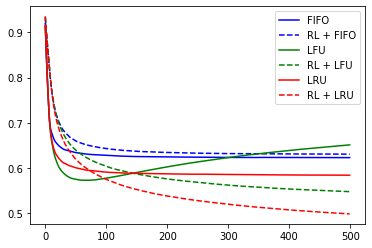

FIFO Connection : 0.6232464413458125
RL + FIFO Connection : 0.6310453189009212
LFU Connection : 0.6514035555359254
RL + LFU Connection : 0.5481230623215914
LRU Connection : 0.5845090187294163
RL + LRU Connection : 0.49896732394702326


In [6]:
RL1_connection = RL_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param, 'FIFO')
RL2_connection = RL_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param, 'LFU')
RL3_connection = RL_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param, 'LRU')
FIFO_connection = FIFO_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param)
LFU_connection = LFU_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param)
LRU_connection = LRU_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param)

t = [n for n in range(N)]

plt.plot(t,FIFO_connection,'b')
plt.plot(t,RL1_connection,'b--')
plt.plot(t,LFU_connection,'g')
plt.plot(t,RL2_connection,'g--')
plt.plot(t,LRU_connection,'r')
plt.plot(t,RL3_connection,'r--')
plt.legend(['FIFO', 'RL + FIFO', 'LFU', 'RL + LFU', 'LRU', 'RL + LRU'])
plt.show()

print('FIFO Connection :',FIFO_connection[N-1])
print('RL + FIFO Connection :',RL1_connection[N-1])
print('LFU Connection :',LFU_connection[N-1])
print('RL + LFU Connection :',RL2_connection[N-1])
print('LRU Connection :',LRU_connection[N-1])
print('RL + LRU Connection :',RL3_connection[N-1])

# by Number of Clients

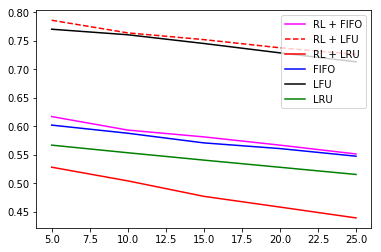

In [13]:
RL1_connection = []
RL2_connection = []
RL3_connection = []
FIFO_connection = []
LFU_connection = []
LRU_connection = []

number_of_clients = [i*5 for i in range(1,6)]

for num in number_of_clients:
    RL1_connection.append(RL_Caching(M, N, num_of_video, num, cache_size, zipf_param, 'FIFO')[N-1])
    RL2_connection.append(RL_Caching(M, N, num_of_video, num, cache_size, zipf_param, 'LFU')[N-1])
    RL3_connection.append(RL_Caching(M, N, num_of_video, num, cache_size, zipf_param, 'LRU')[N-1])
    FIFO_connection.append(FIFO_Caching(M, N, num_of_video, num, cache_size, zipf_param)[N-1])
    LFU_connection.append(LFU_Caching(M, N, num_of_video, num, cache_size, zipf_param)[N-1])
    LRU_connection.append(LRU_Caching(M, N, num_of_video, num, cache_size, zipf_param)[N-1])

plt.plot(number_of_clients, RL1_connection,'magenta')
plt.plot(number_of_clients, RL2_connection,'r--')
plt.plot(number_of_clients, RL3_connection,'r')
plt.plot(number_of_clients, FIFO_connection,'blue')
plt.plot(number_of_clients, LFU_connection,'black')
plt.plot(number_of_clients, LRU_connection,'green')
plt.legend(['RL + FIFO', 'RL + LFU', 'RL + LRU', 'FIFO', 'LFU', 'LRU'])
plt.show()

# by Number of Videos

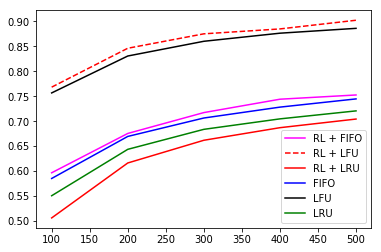

In [15]:
RL1_connection = []
RL2_connection = []
RL3_connection = []
FIFO_connection = []
LFU_connection = []
LRU_connection = []

number_of_videos = [i*100 for i in range(1,6)]

for num in number_of_videos:
    RL1_connection.append(RL_Caching(M, N, num, num_of_client, cache_size, zipf_param, 'FIFO')[N-1])
    RL2_connection.append(RL_Caching(M, N, num, num_of_client, cache_size, zipf_param, 'LFU')[N-1])
    RL3_connection.append(RL_Caching(M, N, num, num_of_client, cache_size, zipf_param, 'LRU')[N-1])
    FIFO_connection.append(FIFO_Caching(M, N, num, num_of_client, cache_size, zipf_param)[N-1])
    LFU_connection.append(LFU_Caching(M, N, num, num_of_client, cache_size, zipf_param)[N-1])
    LRU_connection.append(LRU_Caching(M, N, num, num_of_client, cache_size, zipf_param)[N-1])

plt.plot(number_of_videos, RL1_connection,'magenta')
plt.plot(number_of_videos, RL2_connection,'r--')
plt.plot(number_of_videos, RL3_connection,'r')
plt.plot(number_of_videos, FIFO_connection,'blue')
plt.plot(number_of_videos, LFU_connection,'black')
plt.plot(number_of_videos, LRU_connection,'green')
plt.legend(['RL + FIFO', 'RL + LFU', 'RL + LRU', 'FIFO', 'LFU', 'LRU'])
plt.show()

# by zipf parameter

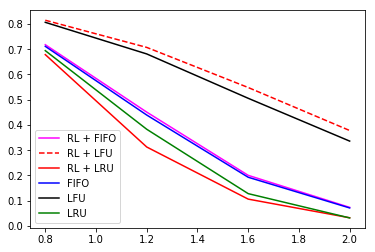

In [18]:
RL1_connection = []
RL2_connection = []
RL3_connection = []
FIFO_connection = []
LFU_connection = []
LRU_connection = []

zipf_parameters = [i*0.4 for i in range(2, 6)]

for zipf_param in zipf_parameters:
    RL1_connection.append(RL_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param, 'FIFO')[N-1])
    RL2_connection.append(RL_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param, 'LFU')[N-1])
    RL3_connection.append(RL_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param, 'LRU')[N-1])
    FIFO_connection.append(FIFO_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param)[N-1])
    LFU_connection.append(LFU_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param)[N-1])
    LRU_connection.append(LRU_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param)[N-1])

plt.plot(zipf_parameters, RL1_connection,'magenta')
plt.plot(zipf_parameters, RL2_connection,'r--')
plt.plot(zipf_parameters, RL3_connection,'r')
plt.plot(zipf_parameters, FIFO_connection,'blue')
plt.plot(zipf_parameters, LFU_connection,'black')
plt.plot(zipf_parameters, LRU_connection,'green')
plt.legend(['RL + FIFO', 'RL + LFU', 'RL + LRU', 'FIFO', 'LFU', 'LRU'])
plt.show()